In [2]:
#from dask import dataframe, delayed
#from dask.distributed import Client
import os
import re
import math
import time
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
from sklearn import preprocessing, metrics, linear_model, metrics, svm, naive_bayes, tree

from sanitization_tools import *
#dataset_path = "/Users/juanzinser/Workspace/Tesis/data/kaggle/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
dataset_path = "census_level_0.csv"
dataset_path = "../data/kaggle/census/adult.csv"


In [62]:
def meta_ds_results(df_path, ds_name, y_col, exclude_cols):
    # benchmark
    privacy, include_real, uniform, uniform2, maybe = 0, True, True, True, False

    data = pd.read_csv(dataset_path)#.sample()
    data = data.sample(int(len(data)/2))
    data = data.dropna()
    data = data[[col for col in data.columns if col not in exclude_cols]]
    data_cols = data.columns

    # selects categorical data
    std_cols = list(set(data.select_dtypes(["number"]).columns).difference({y_col}))
    for col in std_cols:
        data[col] = pd.cut(data[col], bins=10, labels=False).map(str)
    cat_columns = list(set(data.select_dtypes(["bool_", "object_","flexible"],["number"]).columns).difference({y_col}))

    meta_info = get_meta_info_pandas(data, cat_columns, privacy, include_real, uniform, uniform2, maybe, True)
    
    return meta_info

def sanitize_df(df_path, ds_name, y_col, exclude_cols, cases):

    model_dict = dict()
    model_dict["linear_regression"] = linear_model.LinearRegression()
    model_dict["svm"] = svm.SVC(gamma=0.001, C=100.)
    model_dict["naive_bayes"] = naive_bayes.GaussianNB()
    model_dict["tree"] = tree.DecisionTreeRegressor()

    processed_cases = list()
    case_model_scores = dict()
    reco_list = list()
    
    iterator = 0
    for case in cases:

        if iterator > 0:
            privacy, include_real, uniform, uniform2, maybe = case[0], case[1], case[2], case[3], case[4]
            case_name = str(privacy)+("m" if maybe else "t" if include_real else "f") + ("t" if uniform else "f")+("t" if uniform2 else "f")
        else:
            # benchmark
            privacy, include_real, uniform, uniform2, maybe = 0, True, True, True, False
            case_name = "0.0ttt"
        print(case_name)
        if case_name not in processed_cases:
            for rand_num in range(10):
                case_name_rand = case_name +"_"+ str(rand_num)
                display(case_name_rand)

                data = pd.read_csv(dataset_path)#.sample()
                data = data.sample(int(len(data)/2))
                data = data.dropna()
                data = data[[col for col in data.columns if col not in exclude_cols]]
                data_cols = data.columns
                data_y = data[y_col]

                # selects categorical data
                std_cols = list(set(data.select_dtypes(["number"]).columns).difference({y_col}))
                for col in std_cols:
                    data[col] = pd.cut(data[col], bins=10, labels=False).map(str)
                cat_columns = list(set(data.select_dtypes(["bool_", "object_","flexible"],["number"]).columns).difference({y_col}))

                if iterator > 0:
                    meta_info = get_meta_info_pandas(data, cat_columns, privacy, include_real, uniform, uniform2, maybe, False)
                else:
                    meta_info = get_meta_info_pandas(data, cat_columns, privacy, include_real, uniform, uniform2, maybe, True)

                asd = {}
                rmse_dict = {}
                for col in cat_columns:
                    if len(meta_info["columns"][col]["counter"])<50:
                        asd[col] = np.matrix([entry_sanitization_with_maybe(entry=x, **meta_info["algorithm"], **meta_info["columns"][col]) for x in data[col]])
                        rmse_dict[col] = sum([np.power(x-y,2) for x,y in zip(meta_info["columns"][col]["counter"].values(), asd[col].sum(axis=0))])
                nis = pd.DataFrame.from_dict(rmse_dict, orient="index").reset_index()
                nis.columns = ["class", "rmse"]
                nis["case"] = case_name_rand
                reco_list.append(nis)

                dataa =  pd.concat([pd.DataFrame(v, columns=[k+"/"+i for i in meta_info["columns"][k]["key_to_order"].keys()]) for k, v in asd.items()], axis=1)
                if len(data_y.unique())==2:
                    dataa["y"] = (data_y==data_y.unique()[0]).astype(int).values
                else: # in case there is numeric take the median
                    dataa["y"] = (data_y>=sorted(data_y)[int(len(data_y)/2)]).astype(int).values
                dataa = dataa.dropna()
                display(dataa.head())
                case_model_scores[case_name_rand] = dict()
                for model_name, model in model_dict.items():
                    try:
                        case_model_scores[case_name_rand][model_name] = get_auc_score_of_model(dataa, model)#[:2]
                    except exception as e:
                        print(e)
                    display(model_name + str(case_model_scores[case_name_rand][model_name][:2]))
                clear_output(wait=True)
            processed_cases.append(case_name)
            iterator += 1
            
    timestr = time.strftime("%Y%m%d")

    reco_df = pd.concat(reco_list)
    reco_df.to_csv("supervised_rmse_df_"+ds_name+timestr+".csv")

    df_models_scores = pd.DataFrame.from_dict(case_model_scores, orient="index").reset_index().rename(columns={"index":"case"})
    df_models_scores = df_models_scores.melt(id_vars=df_models_scores.columns[0], value_vars=df_models_scores.columns[1:], value_name="models")
    df_models_scores = pn.DataFrame.from_dict(case_model_scores, orient="index").reset_index().rename(columns={"index":"case"})
    df_models_scores = df_models_scores.melt(id_vars=["case"]).rename(columns={"variable":"model"})


    df_models_scores["privacy"] = df_models_scores["case"].map(lambda x: int("".join(re.findall("\d+", x)[:2])))
    df_models_scores["real"] = df_models_scores["case"].map(lambda x: re.findall("[^\d]",x)[1])
    df_models_scores["uniform"] = df_models_scores["case"].map(lambda x: int(re.findall("[^\d]",x)[2] == "t"))
    df_models_scores["uniform2"] = df_models_scores["case"].map(lambda x: int(re.findall("[^\d]",x)[3] == "t"))

    df_models_scores["error"] = df_models_scores["value"].map(lambda x: x[0])
    df_models_scores["auc"] = df_models_scores["value"].map(lambda x: x[1])

    def all_entries_vector(x):
        xs = ""
        for xi in x:
            xs += str(xi) + ","
        return xs[:-1]

    df_models_scores["roc_x"] = df_models_scores["value"].map(lambda x: all_entries_vector(x[2][0]))
    df_models_scores["roc_y"] = df_models_scores["value"].map(lambda x: all_entries_vector(x[2][1]))
    df_models = df_models_scores[["case", "model", "privacy", "real", "uniform", "uniform2", "error", "auc", "roc_x", "roc_y"]]
    df_models.columns = [["case", "model", "privacy", "real", "uniform", "uniform2", "error", "auc", "roc_x", "roc_y"]]
    df_models.to_csv("model_scores_roc_"+ds_name+timestr+".csv")

In [60]:
cases = [[1, True, True, True, False]]
for pr in range(1,11):
    cases += [
[pr/10, False, True, True, False],
                  [pr/10, True, True, True, False],
                  [pr/10, False, True, True, True],
                  [pr/10, True, False, False, False],
                  [pr/10, False, False, False, False],
                  [pr/10, False, False, False, True]
             ]
ds_name="income"
y_col = "salary-class"
y_col = "income"
exclude_cols = ["lat", "lon", "hostel.name", "Distance"]
df_path = "census_level_0.csv"
df_path = dataset_path
#sanitize_df(df_path, ds_name, y_col, exclude_cols, cases)

In [84]:
df_eda = {}
for ds_name, df_path, y_col in [("income", "../data/kaagle/census/adult.csv", "income"),
                                ("insurance","../data/kaggle/insurance/insurance.csv","charges"),
                                ("churn","../data/kaggle/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", "Churn")]:
    exclude_cols = ["lat", "lon", "hostel.name", "Distance"]
    df_eda[ds_name] = meta_ds_results(df_path, ds_name, y_col, exclude_cols)

In [79]:
def plot_intervals_smooth_info(df, gb_param, yaxis, base_filter, lines_cases, savefig=False,  title=None, save_name=None,
                   language="english"):
    """
    Returns a line plot with quantile intervals of the RMSE of different levels of either privacy or number of classes.
    Works only for the non-supervised datasets since there are multiples simulations for provacy levels and numberr of classes.
    
    """
    fig, ax = plt.subplots()
    pt = base_filter.get("privacy")
    if pt is not None:
        base_filter.pop("privacy")
        df = df.query("privacy < {pt}".format(pt=pt))
    df = get_base_filtered_df(df, base_filter)
    labels = []
    if "uniform" in df.columns:    
        df = df[df.uniform == df.uniform2]
    y_max = 0
    intersect_line = []
    if len(lines_cases)>0:
        for k, v in lines_cases.items():
            v = [v] if not isinstance(v, list) else v
            for v0 in v:
                dfc = get_single_filter_df(df, k, v0)
                gb = dfc.groupby([gb_param])[yaxis].quantile([.1,.25,.5,.75,0.9]).reset_index()
                x = gb[gb_param].unique()
                xnew = np.linspace(x.min(),x.max(),300) #300 represents number of points to make between T.min and T.max
                y1 = spline(x, gb.query("level_1 == 0.25")[yaxis], xnew)
                y2 = spline(x, gb.query("level_1 == 0.50")[yaxis], xnew)
                y3 = spline(x, gb.query("level_1 == 0.75")[yaxis], xnew)
                intersect_line.append((xnew, y1))
                ax.fill_between(xnew, y1, y3, color='grey', alpha='0.5')
                ax.plot(xnew, y2)
                param_dict = {k: v0}
                tt = get_label_name(param_dict, True, language)
                labels.append(tt)
                lines, _ = ax.get_legend_handles_labels()
                y_max = max(y_max, max(y2))
    else:
        gb = df.groupby([gb_param])[yaxis].quantile([.1,.25,.5,.75,0.9]).reset_index()
        x = gb[gb_param].unique()
        xnew = np.linspace(x.min(),x.max(),300) #300 represents number of points to make between T.min and T.max
        y1 = spline(x, gb.query("level_1 == 0.25")[yaxis], xnew)
        y2 = spline(x, gb.query("level_1 == 0.50")[yaxis], xnew)
        y3 = spline(x, gb.query("level_1 == 0.75")[yaxis], xnew)
        ax.fill_between(xnew, y1, y3, color='grey', alpha='0.5')
        ax.plot(xnew,y2)
        tt = get_label_name(base_filter, True, language)
        labels.append(tt)
        lines, _ = ax.get_legend_handles_labels()
        y_max = max(y_max, max(y2))

    ax.legend(lines, labels, loc='best')
    ax.set_title(title)
    #ax.set_ylim([0, y_max*1.5])
    dict_use = english_dict if language == "english" else spanish_dict
    gb_param = dict_use.get(gb_param.lower()) if dict_use.get(gb_param.lower()) else gb_param
    yaxis = dict_use.get(yaxis.lower()) if dict_use.get(yaxis.lower()) else yaxis
    ax.set_xlabel(gb_param.upper())
    ax.set_ylabel(yaxis.upper())
    if yaxis=="auc":
        ax.yaxis.set_major_formatter(FormatStrFormatter(y_tick_format))
    else:
        ax.yaxis.set_major_formatter(y_tick_format_int)
    if gb_param == "privacy":
        ax.xaxis.set_major_formatter(x_tick_percent)
    plt.tight_layout()
    if savefig:
        plt.savefig(figures_path + save_name + ".png")
    plt.show()
    return intersect_line


In [18]:
data = pd.read_csv(dataset_path)

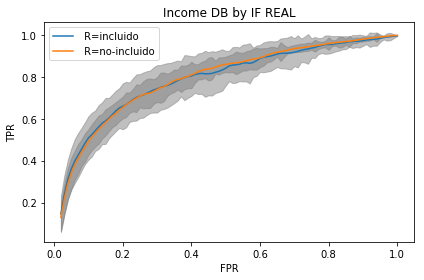

Series([], Name: auc, dtype: float64)


/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


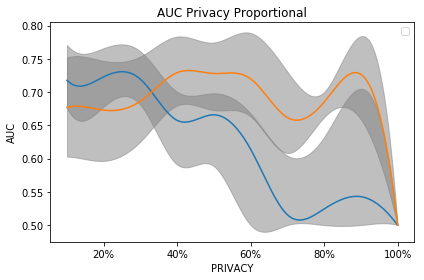

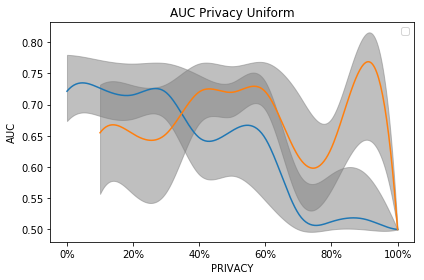

In [37]:
ds_name="churn"

#supervised_results = pd.concat([pn.read_csv("model_scores_roc_census06_mbe.csv"), pd.read_csv("model_scores_roc_census611_mbe.csv")])
supervised_results = pd.read_csv("model_scores_roc_"+ds_name+"011.csv")
rocs_by_case(supervised_results, {},{"real":["t","f"]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")
#rocs_by_case(supervised_results, {"real":"m"},{"privacy":[1,2,3,4,5,7,9]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")

print(supervised_results[supervised_results.real=="m"].groupby("privacy")["auc"].agg(lambda x:np.average(x)))


intersect = plot_intervals_smooth_info(supervised_results, "privacy","auc", {"uniform":[0], "uniform2":[0]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Proportional", save_name=ds_name+"_auc_real_proportional")
intersection_pnt = [intersect[0][0][i]  for i in range(len(intersect[0][0])) if (abs(intersect[0][1][i]-intersect[1][1][i]) < .005)][0]

intersect = plot_intervals_smooth_info(supervised_results, "privacy","auc", {"uniform":[1], "uniform2":[1]}, 
               {"real":["t", "f"]}, savefig=True, 
               title="AUC Privacy Uniform", save_name=ds_name+"_auc_real_uniform")
intersection_pnt = [intersect[0][0][i]  for i in range(len(intersect[0][0])) if (abs(intersect[0][1][i]-intersect[1][1][i]) < .005)][0]


In [80]:
ds_name="churn"

def meta_results(ds_name):

    #supervised_results = pd.concat([pn.read_csv("model_scores_roc_census06_mbe.csv"), pd.read_csv("model_scores_roc_census611_mbe.csv")])
    supervised_results = pd.read_csv("model_scores_roc_"+ds_name+"011.csv")
    rocs_by_case(supervised_results, {},{"real":["t","f"]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")
    #rocs_by_case(supervised_results, {"real":"m"},{"privacy":[1,2,3,4,5,7,9]}, savefig=True, title="by IF REAL", save_name=ds_name+"_roc_privacy_grouped_tmf",language="spanish")

    print(supervised_results[supervised_results.real=="m"].groupby("privacy")["auc"].agg(lambda x:np.average(x)))

    result_dict = {}
    result_dict["benchmark_auc"] = supervised_results[supervised_results.privacy==0].groupby("privacy")["auc"].agg(lambda x:np.average(x))[0]
    intersect = plot_intervals_smooth_info(supervised_results, "privacy","auc", {"uniform":[0], "uniform2":[0]}, 
                   {"real":["t", "f"]}, savefig=True, 
                   title="AUC Privacy Proportional", save_name=ds_name+"_auc_real_proportional")
    intersection_pnt = [intersect[0][0][i]  for i in range(len(intersect[0][0])) if (abs(intersect[0][1][i]-intersect[1][1][i]) < .005)][0]
    result_dict["proportional"] = intersection_pnt
    
    intersect = plot_intervals_smooth_info(supervised_results, "privacy","auc", {"uniform":[1], "uniform2":[1]}, 
                   {"real":["t", "f"]}, savefig=True, 
                   title="AUC Privacy Uniform", save_name=ds_name+"_auc_real_uniform")
    intersection_pnt = [intersect[0][0][i]  for i in range(len(intersect[0][0])) if (abs(intersect[0][1][i]-intersect[1][1][i]) < .005)][0]
    result_dict["uniform"] = intersection_pnt
    return result_dict

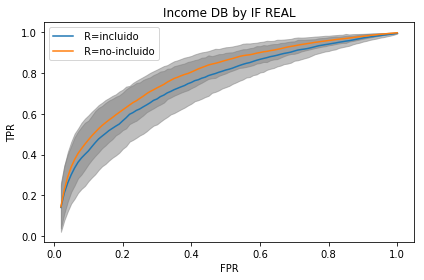

privacy
1     0.499256
2     0.498918
3     0.500770
4     0.501125
5     0.498309
6     0.499828
7     0.499504
8     0.500269
9     0.500234
10    0.500000
Name: auc, dtype: float64


/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


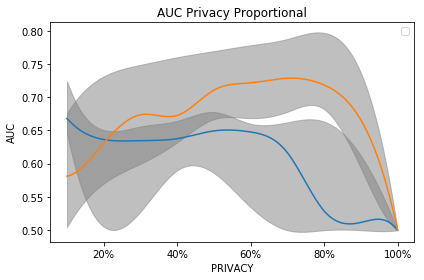

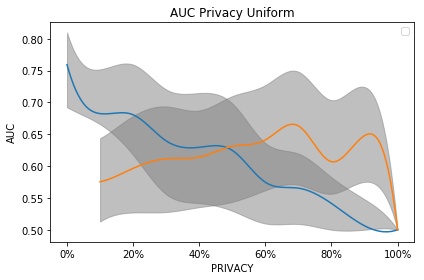

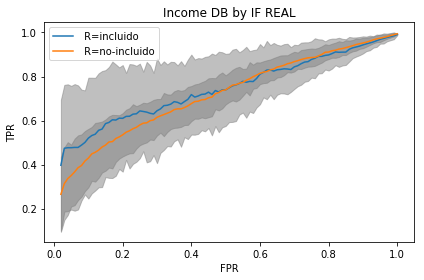

Series([], Name: auc, dtype: float64)


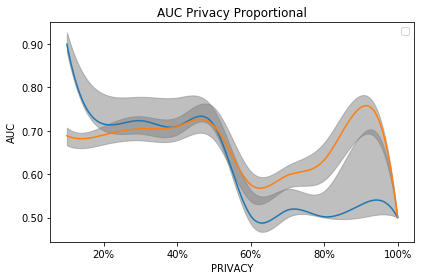

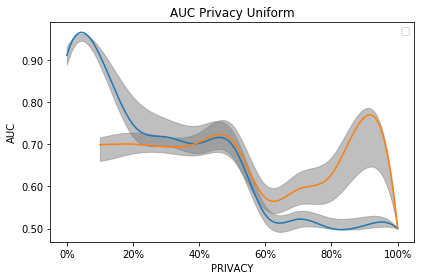

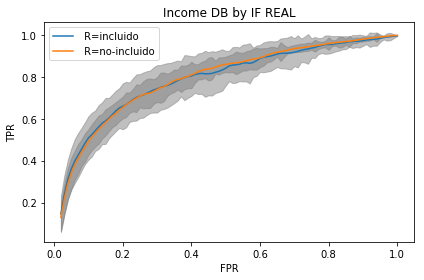

Series([], Name: auc, dtype: float64)


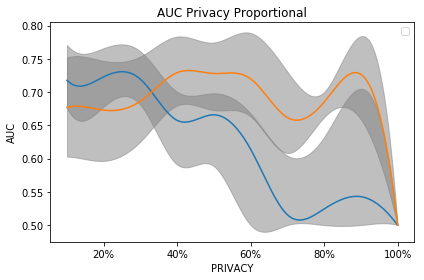

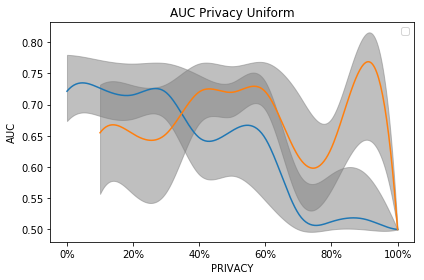

In [112]:
ds_meta_results = {}
for ds in ["income", "insurance", "churn"]:
    # what info can be added from the original ds that can be compared, 
    # and have significance with the sanitized results
    # ds columns, avg categories per sanitized column, benchmark auc
    #col_vals = [np.average(list(df_eda[ds]["columns"][i]["counter"].values())) for i in list(df_eda[ds]["columns"].keys())]
    #col_vals = [len(df_eda[ds]["columns"][i]["counter"]) for i in list(df_eda[ds]["columns"].keys())]
    col_vals = [np.std(list(df_eda[ds]["columns"][i]["counter"].values()))/np.average(list(df_eda[ds]["columns"][i]["counter"].values())) for i in list(df_eda[ds]["columns"].keys())]
    avg_cols = np.average(col_vals)
    std_cols = np.std(col_vals)
    ds_meta_results[ds] = dict(meta_results(ds), **{"avg_col":avg_cols, "std_col":std_cols})

In [108]:
result = pd.DataFrame(ds_meta_results).T

In [109]:
print(result)

            avg_col  benchmark_auc  proportional   std_col   uniform
churn      1.637847       0.735360      3.347826  1.256385  3.177258
income     1.721819       0.748603      1.511706  1.260580  3.745819
insurance  1.627911       0.909971      5.304348  1.239237  3.612040


In [77]:
print(meta_results["income"]["columns"]["race"]["counter"])

{'Asian-Pac-Islander': 551, 'White': 13872, 'Amer-Indian-Eskimo': 158, 'Other': 141, 'Black': 1558}


In [111]:
1+np.sqrt(5)/2-.5

1.618033988749895

In [113]:
from sklearn import linear_model 

In [119]:
lm = linear_model.LinearRegression()
lm.fit(result[[col for col in result.columns if col not in ["proportional","uniform"]]], result["uniform"])

/Users/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
lm.coef_

array([6.3123965 , 2.86282258, 0.13886063])